# **Classificatore forme**

Il seguente progetto implementa la classificazione delle forme geometriche fornite ricorrendo a diversi approcci in fatto di rappresentazione dei dati forniti e di modelli di predizione. 
* **Rappresentazione dei dati**: per quanto riguarda la descrizione utilizzata al fine della classificazione si ricorre sia all'utilizzo della rappresentazione originale fornita dalla traccia che ad una rappresentazione alternativa che comunque non ricorre ad alterazioni o aggiunte ai dati forniti. In particolare vengono proposti approcci di Feature Extraction (PCA) e Feature Selection (Feature Importance) sui dati in forma originale, al fine di ridurre la dimensionalità dei campioni e quindi un'alleggerimento del carico computazionale nella fase di addestramento, ma anche al fine di restituire informazioni circa le quantità di informazioni contenute nelle features.
La rappresentazione alternativa invece propone di rappresentare ogni campione attraverso le distanze tra i punti consecutivi che lo compongnono, andandole a calcolare proprio a partire dai punti estratti dalla funzione generatrice dei campioni. Questa strategia oltre a dare l'eventuale possibilità di calcolare nuove feature (ad esempio il perimetro come somma delle distanze locali), permette di rappresentare un campione con un numero decisamente inferiore di feature ovvero $n_{punti} - 1$ anziché $2 \cdot n_{punti} $ come nel caso di partenza.
* **Model Selection**: i modelli di classificazione scelti sono Logistic Regression, Support Vector Machine e Multi Layer Perceptron. La Model Selection è stata effettuata utilizzando il modello GridSearchCV di ScikitLearn che permette, per ogni classificatore proposto, di effettuare una "ricerca a griglia" all'interno dello spazio degli iperparametri proposti per ognuno di essi; dunque tale modello andrà ad effettuare una cross-validation sul Training Set fornito con un certo numero di fold e provare ogni possibile configurazione di iperparametri per poi restituire quella che restituisce un punteggio migliore, che in questo caso corrisponde all'accuracy sui vari validation set generati.

---

# Importazione librerie necessarie

In [71]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from time import time
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.svm             import SVC
from sklearn.tree   import DecisionTreeClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics         import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve, auc
from itertools import combinations
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Generazione

In [2]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

### Generazione Dataset
- Le funzioni di generazione del dataset fornite vanno a generare *n_shapes* campioni di ogni tipo di forma considerato, andandole a generare come liste di punti (coppie di coordinate (x,y)) e raccolte in un'unica lista che è il dataset; poi viene anche restituita la lista y delle etichette di ogni forma generata [0 = ellisse, 1 = rettangolo, 2 = segmento, 3 = croce].

In [3]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
        

    return np.array(X), np.array(y)  # restituisce array di campioni e etichette


Rappresentazione vettoriale originale proposta dalla traccia del progetto consistente nella sequenza di coordinate di ogni punto di una forma

In [4]:
def get_vector_representation(X):
    return np.array([list(x.flatten()) for x in X])

Rappresentazione vettoriale alternativa consistente nel calcolo delle distanze locali dei punti di una forma.
- A tal fine si vanno a calcolare le differenze tra punti consecutivi forniti dalla funzione `genera_campioni` sotto forma di coppie di coordinate, per poi calcolarne la 
norma di ognuno
- Questa rappresentazione alternativa permette di ottenere una descrizione del dataset molto più sintetica rispetto a quella originale in quanto vengono utilizzate un numero di feature per ogni forma pari a *(n_punti - 1)* anziché *2 * n_punti*


In [4]:
def get_vector_representation_2(X):
    n_punti_forma = X.shape[1]
    X_reshaped = X.reshape(-1, n_punti_forma, 2)      # converte X di forma (n_shape*n_punti,2) in X_reshaped di forma(n_shape, n_punti, 2)
    vettori = X_reshaped[:, 1:, :] - X_reshaped[:, :-1, :]  # differenze tra punti consecutivi
    distanze = np.linalg.norm(vettori, axis=2)             # norma lungo asse delle componenti (x,y)
     
    return distanze

In [5]:
def ottieni_features(X):
    return get_vector_representation(X)

In [5]:
def ottieni_features_2(X):
    return get_vector_representation_2(X)

In [6]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

---

# 1. **Rappresentazione e Feature engineering** 

## Costruzione dataset
Si va a generare il dataset ricorrendo alla rappresentazione delle forme tramite sequenza di coordinate "appiattita"

* Costruiamo il dataset `flat` richiamando la funzione originale `ottieni_features`

In [7]:
X, y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.00001)

In [8]:
X_flat = ottieni_features(X) # rappresentazione tramite vettore appiattito

## 1.1 Feature engineering su dataset originale

Andiamo ad effettuare lo splitting del dataset per ottenere il training set `(X_train, y_train)` ed il test set `(X_test, y_test)` ricorrendo ad una proporzione *70%/30%*

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)


Print delle dimensioni di ogni sottoinsieme:

In [10]:
print("Shape di X_train:", X_train.shape)
print("Shape di X_test:", X_test.shape)

Shape di X_train: (2800, 200)
Shape di X_test: (1200, 200)


### 1.1.1 Standardizzazione delle Features e applicazione del metodo della PCA
- Si va prima di tutto a standardizzare i valori delle Features per tenere i valori di ogni componente sulla stessa scala;
- Dopodiché si applica il metodo della PCA, tramite implementazione del codice visto a lezione, al fine di ridurre la dimensionalità di ogni campione e quindi facilitare la fase di Fitting del modello predittivo.

In [11]:
# Definizione funzione get_eigen(A) necessaria al calcolo della matrice di covarianza ed i relativi autovettori e autovalori

def get_eigen(A):
    # calcola la media per ogni colonna (feature)
    means = np.mean(A, axis=0)
    # sottrae la media (lungo le colonne): ogni feature ora ha media zero
    M = (A - means)
    # calcola la matrice di covarianza delle righe di A
    c = np.cov(M, rowvar=0)
    # calcola autovalori e autovettori della matrice di covarianza
    [evals, evects] = np.linalg.eig(c)
    # ottiene gli indici degli autovalori ordinati in modo decrescente
    idx = np.argsort(evals)[::-1]
    # ordina gli autovettori (colonne di evects) secondo gli autovalori ordinati
    evects = evects[:, idx]
    # ordina gli autovalori in modo decrescente
    evals = evals[idx]
    return evals, evects, M

# Definizione della funzione pca che va a creare la base formata dagli autovettori e ad effettuare le proiezioni della matrice di covarianza su tale base.

def pca(M, vec, numpc=0):
    # Estrae i primi 'numpc' autovettori come base dello spazio ridotto
    basis = vec[:, range(numpc)]
    # Proietta i dati centrati nello spazio delle componenti principali
    projections = np.dot(M, basis)
    # Restituisce la base e le proiezioni
    return basis, projections

* Costruzione di uno scaler dalla libreria di Scikitlearn e trasformazione sia del Training Set che del Test Set

In [12]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

* Applicazione della PCA ad entrambi i sotto-dataset specificando un numero di componenti principali da mantenere pari a **20**

In [13]:
numpc = 11

# Calcolo autovalori, autovettori e M_train centrate sulla media di X_train_std
evals_train, evects_train, M_train = get_eigen(X_train_std)

# Proietto TRAIN
basis_train, proiezioni_train = pca(M_train, evects_train, numpc=numpc)

# ------- 4. PCA sul TEST usando la STESSA base e media del TRAIN -------
# Ricostruisco M_test sottraendo la media di X_train_std
means_train = np.mean(X_train_std, axis=0)
M_test = X_test_std - means_train

# Richiamo pca con vec = evects_train (gli stessi usati per il train)
basis_test, proiezioni_test = pca(M_test, evects_train, numpc=numpc)

* Rappresentazione grafica comparando le figure originali con quelle ricostruite utilizzando le componenti principali estratte

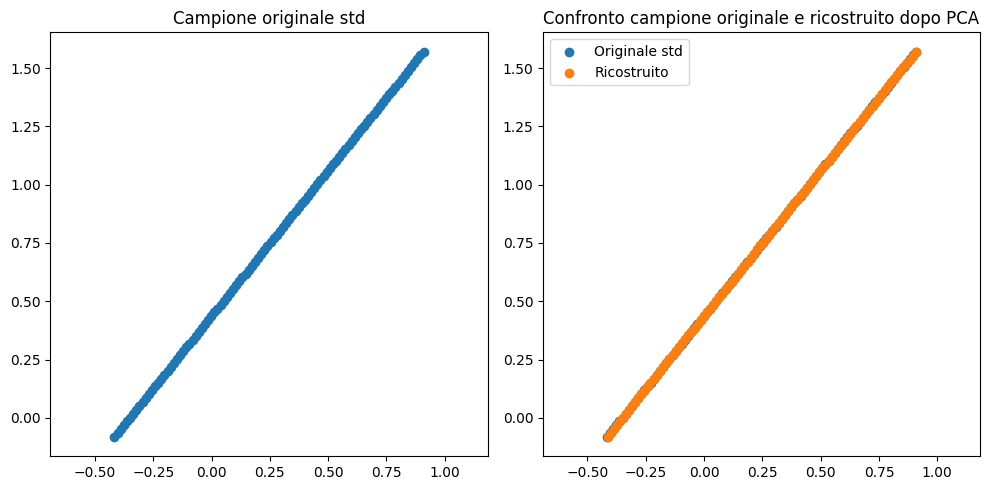

In [14]:

i = np.random.randint(low=1, high=1000)


# 1) ricostruzione dell'intero train set in scala standard
M_recon = proiezioni_train.dot(basis_train.T)                     # dati centrati ricostruiti
means_train = np.mean(X_train_std, axis=0)                        # media del train set standardizzato
X_recon_std = M_recon + means_train                               # riaggiungo la media
# se vuoi riportare nello spazio originale:
X_recon = scaler.inverse_transform(X_recon_std)                  

# 2) estrai il campione originale e quello ricostruito
orig_sample  = X_train[i].reshape(-1, 2)
recon_sample = X_recon[i].reshape(-1, 2)

# 3) plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# subplot 1: campione originale
ax1.scatter(orig_sample[:,0], orig_sample[:,1])
ax1.set_title("Campione originale std")
ax1.axis('equal')

# subplot 2: confronto originale vs ricostruito
ax2.scatter(orig_sample[:,0],  orig_sample[:,1],  label="Originale std")
ax2.scatter(recon_sample[:,0], recon_sample[:,1], label="Ricostruito")
ax2.set_title("Confronto campione originale e ricostruito dopo PCA")
ax2.axis('equal')
ax2.legend()

plt.tight_layout()
plt.show()

### 1.1.2 Feature selection e valutazione


- Per applicare la Feature Selection si ricorre all'utilizzo del modello `Random Forest` che permette di restituire la misura di *importanza* delle feature del dataset basandosi sulla somma totale di *information gain* relativa ad ogni feature. 
- Dunque verrà specificato il numero di Decision Tree all'interno della foresta e poi addestrato il modello per raccogliere le feature che vengono scelte in base ad una soglia minima `importance_threshold` che specifica la percentuale di importanza che una feature deve avere per poter essere mantenuta.

In [21]:
param_grid_fs = {
    'n_estimators': [75, 90, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [12, 15, 20],
    'min_samples_split': [3, 5, 10],
}

gs_fs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_fs,
    cv=7,
    scoring='accuracy',
    n_jobs=-1
)

In [22]:
fs_randomforest = gs_fs.fit(X_train_std, y_train)
print("\nBest RF params:", gs_fs.best_params_)
print("Best score: \n",    gs_fs.best_score_)


Best RF params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 75}
Best score: 
 0.7482142857142857


* Dopo aver addestrato il modello sul train set, otteniamo le features più importanti, ottenute automaticamente dall'addestramento stesso

In [23]:
importances_rf = fs_randomforest.best_estimator_.feature_importances_

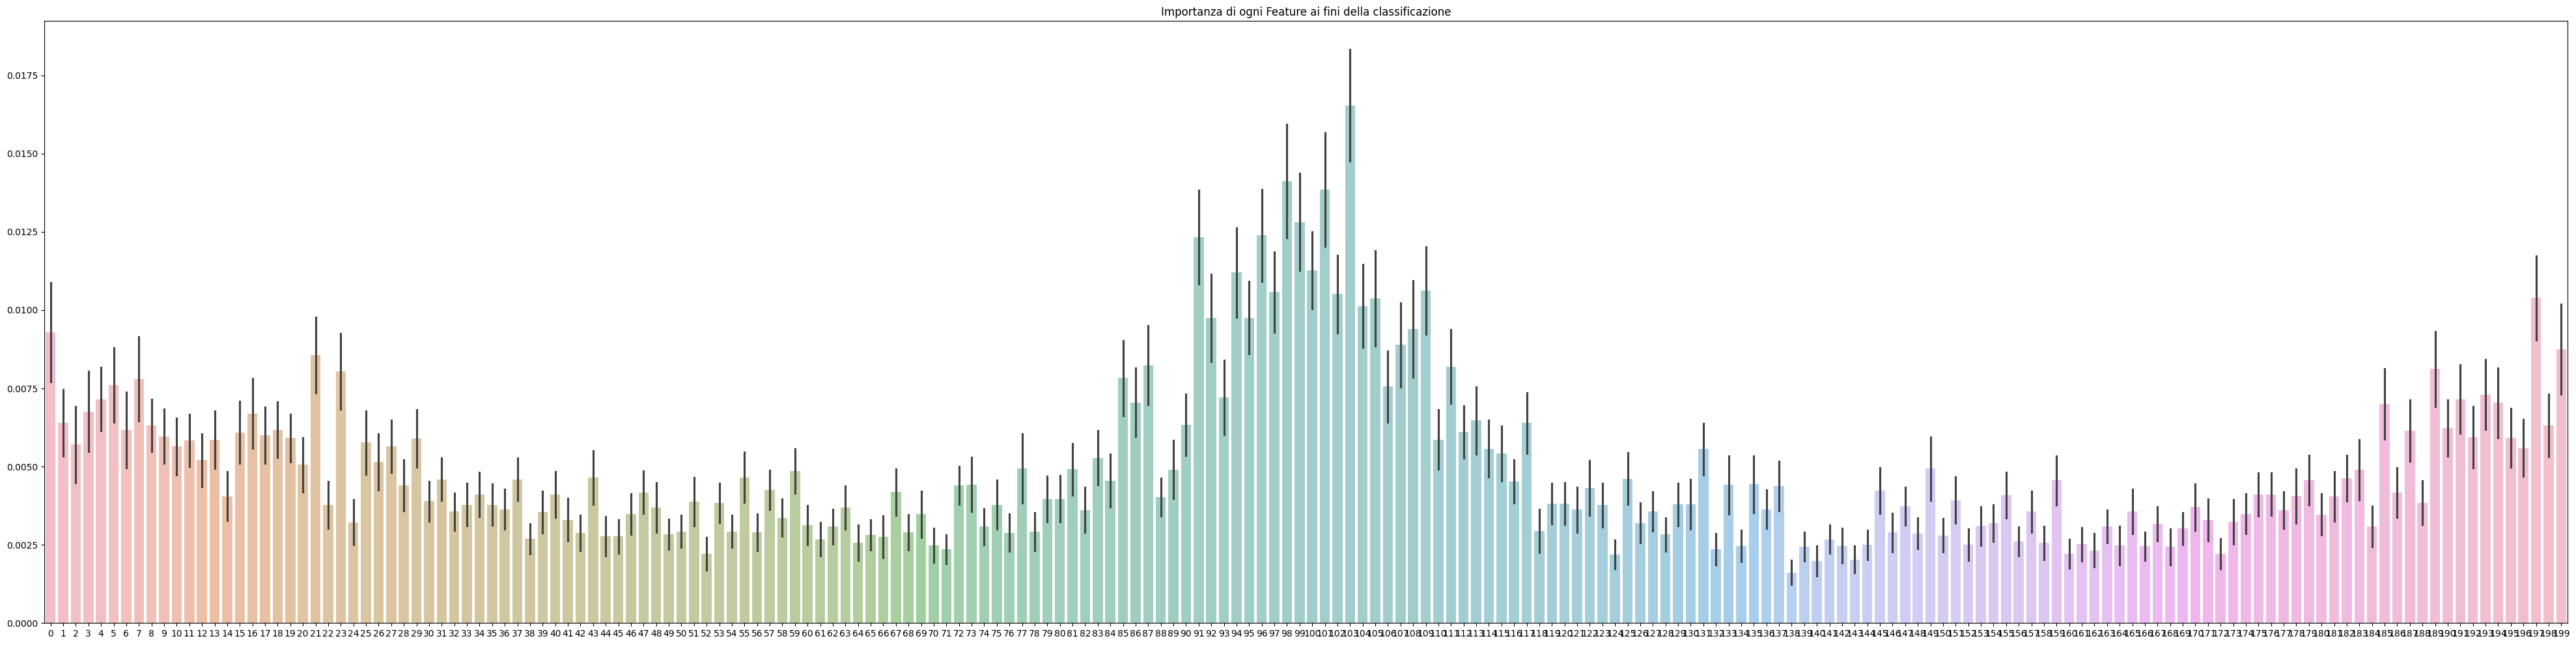

In [84]:
stime_features = np.array([x.feature_importances_ for x in fs_randomforest.best_estimator_.estimators_])
fig = plt.figure(figsize=(50,12))
sns.barplot(data=stime_features, errorbar="se", alpha=0.5)
plt.title('Importanza di ogni Feature ai fini della classificazione')
plt.show()

In [24]:
n_samples, total_feats = X_train.shape
n_points = total_feats // 2

importances_pt = importances_rf.reshape(n_points, 2).sum(axis=1)

thresh_pt = np.percentile(importances_pt, 80) # isolamento del 90% dei punti selezionati
mask_pts = importances_pt >= thresh_pt

X_pts = X_train.reshape(n_samples, n_points, 2)
X_train_sel = X_pts[:, mask_pts, :]   # (n_samples, n_kept, 2)

X_test_sel = X_test.reshape(X_test_std.shape[0], n_points, 2)[:, mask_pts, :]

Rappresentazione grafica della ricostruzione delle forme utilizzando solo le feature estratte dalla precedente classificazione

La Feature Selection in questo caso restituisce i punti più importanti, quindi le feature con maggiore importanza calcolata dalla random forest, che risultano essere quelli agli estremi delle forme.

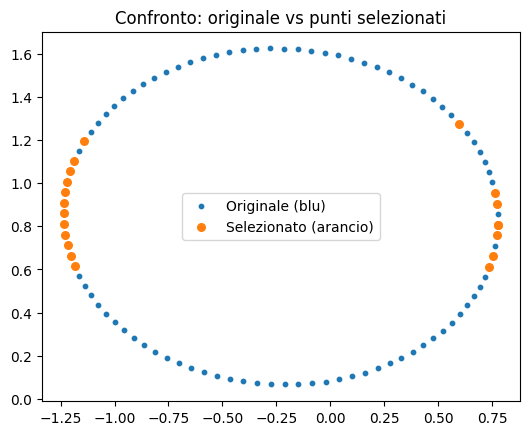

In [25]:
i = np.random.randint(0, n_samples)
orig = X_pts[i]        # (n_points, 2)
sel = X_train_sel[i]   # (n_kept,   2)

fig, ax = plt.subplots()
ax.scatter(orig[:,0], orig[:,1], s=10, label="Originale (blu)")
ax.scatter(sel[:,0],  sel[:,1],  s=30, label="Selezionato (arancio)")
ax.set_aspect('equal', 'box')
ax.set_title("Confronto: originale vs punti selezionati")
ax.legend()
plt.show()

## 1.2 Estrazione nuove features

**Costruiamo un nuovo dataset contenente nuove features per ogni forma. Queste nuove features sono:**
* Distanza dal centroide
* Perimetro
* Area
* Distanza tra i punti estremi

In [ ]:
def extract_geometric_features(pts):
    """
    pts: array (n_punti, 2)
    Restituisce un dict con le feature geometriche.
    """
    # Centroide
    cx, cy = pts.mean(axis=0)
    # distanze dal centroide
    dists = np.linalg.norm(pts - (cx, cy), axis=1)
    dist_mean = dists.mean()
    dist_std  = dists.std()

    # Perimetro
    diffs = np.diff(pts, axis=0, append=pts[:1])
    perimeter = np.linalg.norm(diffs, axis=1).sum()

    # Area
    x, y = pts[:,0], pts[:,1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    # Distanza dagli estremi
    dists_all = [np.linalg.norm(p-q) for p, q in combinations(pts, 2)]
    d_max = max(dists_all)
    d_min = min(dists_all)


    feats = {
        'dist_mean': dist_mean,
        'dist_std':  dist_std,
        'perimeter': perimeter,
        'area':      area,
        'd_max':     d_max,
        'd_min':     d_min,
    }
    return feats
    

* Costruiamo ora il nuovo dataset 

In [31]:
features_list = []
for shape, lbl in zip(X, y):
    feats = extract_geometric_features(shape)
    feats['label'] = lbl
    features_list.append(feats)
df_geo = pd.DataFrame(features_list) 

In [32]:
X_geo = df_geo.drop(columns=['label']).values   
y_geo = df_geo['label'].values

In [33]:
X_train_geo, X_test_geo, y_train_geo, y_test_geo = train_test_split(
    X_geo, y_geo,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## 1.3 Rappresentazione alternativa delle forme

Si va a generare il dataset relativo alla rappresentazione alternativa implementata in `get_vector_representation_2(X)` e poi alla valutazione della classificazione tramite utilizzo di un modello MLP per vedere come si comporta.

In [8]:
X_alternative = ottieni_features_2(X)
print("Shape di X_alternative:", X_alternative.shape)

Shape di X_alternative: (4000, 99)


In [9]:
X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X_alternative, y
)

* Standardizziamo le componenti, poichè presentano valori diversi tra loro

In [10]:
X_train_alt_std = StandardScaler().fit_transform(X_train_alt)
X_test_alt_std = StandardScaler().fit_transform(X_test_alt)

# 2. **Costruzione e valutazione di classificatori**

In questo paragrafo vengono implementati modelli `GrdiSearchCV` per effettuare prima di tutto la model selection per trovare migliori iperparametri per ogni classificatore, per poi effettuare l'addestramento e la classificazione per ogni dataset considerato.

## 2.1.1 Classificazione PCA

Verranno istanziati e addestrati 3 modelli: 
- **Random Forest**;
- **Support Vector Machine** con iperparametro `kernel=[rbf]` per permettere una classificazione di dati non linearmene separabili ricorrendo a tale opzione per trasformare lo spazio dei dati in uno che li renda linearmente separabili;
- **Multi Layer Perceptron** con funzione di attivazione `logistic` che corrisponde alla funzione *sigmoide* e solver `sgd` per specificare l'algoritmo di ottimizzazione della funzione di costo. Consideriamo un MLP con solo uno strato nascosto in quanto fa riferimento a quello visto nella teoria.

* Ottenimento dei dati ridotti dalle trasformazioni `PCA`

In [15]:
X_train_pca = proiezioni_train
X_test_pca  = proiezioni_test
print(X_train_pca.shape)

(2800, 11)


* *Generazione del GridSearch per ottimizzazione iperparametri*

In [19]:
param_grid_rf = {
    'n_estimators': [15, 25 ,50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [7, 9, 12],
    'min_samples_split': [3, 5, 10],
}
param_grid_svm = {
    'C': [50, 70, 90],
    'gamma': [0.001, 0.002, 0.005],
    'kernel': ['rbf'],
}
param_grid_mlp = {
    'hidden_layer_sizes': [(25,), (50,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [20]:
gs_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

gs_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_mlp = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

In [21]:
start_time_rf = time()
print("Tuning RandomForestClassifier...")
gs_rf.fit(X_train_pca, y_train)
end_time_rf = time()

start_time_svm = time()
print("Tuning SVM...")
gs_svm.fit(X_train_pca, y_train)
end_time_svm = time()

start_time_mlp = time()
print("Tuning MLP...")
gs_mlp.fit(X_train_pca, y_train)
end_time_mlp = time()

Tuning RandomForestClassifier...


Tuning SVM...
Tuning MLP...


In [22]:
minuti_impiegati_rf = (end_time_rf-start_time_rf)/60
print(f"Tempo trascorso in minuti RandomForest: {minuti_impiegati_rf:.2f}")
print("\nBest RF params:", gs_rf.best_params_)
print("Best score: \n",    gs_rf.best_score_)

minuti_impiegati_svm = (end_time_svm-start_time_svm)/60
print(f"\nTempo trascorso in minuti SVM: {minuti_impiegati_svm:.2f}")
print("\nBest SVM params:", gs_svm.best_params_)
print("Best score: \n",      gs_svm.best_score_)

minuti_impiegati_mlp = (end_time_mlp-start_time_mlp)/60
print(f"\nTempo trascorso in minuti MLP: {minuti_impiegati_mlp:.2f}")
print("\nBest MLP params:", gs_mlp.best_params_)
print("Best accuracy:",      gs_mlp.best_score_)

Tempo trascorso in minuti RandomForest: 0.24

Best RF params: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 50}
Best score: 
 0.9907142857142859

Tempo trascorso in minuti SVM: 0.07

Best SVM params: {'C': 90, 'gamma': 0.005, 'kernel': 'rbf'}
Best score: 
 0.8407142857142856

Tempo trascorso in minuti MLP: 4.63

Best MLP params: {'activation': 'logistic', 'alpha': 0.001, 'batch_size': 70, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 200, 'solver': 'sgd'}
Best accuracy: 0.9292857142857143


### *Random Forest*

In [23]:
best_rf = gs_rf.best_estimator_
y_test_pred_rf = best_rf.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf, digits=3))

Val Acc: 0.995
              precision    recall  f1-score   support

           0      0.987     0.997     0.992       300
           1      0.997     0.987     0.992       300
           2      0.997     1.000     0.998       300
           3      1.000     0.997     0.998       300

    accuracy                          0.995      1200
   macro avg      0.995     0.995     0.995      1200
weighted avg      0.995     0.995     0.995      1200



**Confusion Matrix**

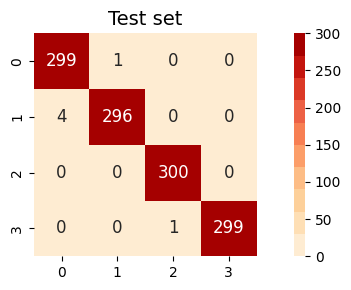

In [25]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_rf),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

### *Support Vector Machines*

In [26]:
best_svm = gs_svm.best_estimator_
y_test_pred_svm = best_svm.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_svm))
print(classification_report(y_test, y_test_pred_svm, digits=3))

Val Acc: 0.8341666666666666
              precision    recall  f1-score   support

           0      0.912     0.690     0.786       300
           1      0.748     0.870     0.804       300
           2      0.895     0.853     0.874       300
           3      0.820     0.923     0.868       300

    accuracy                          0.834      1200
   macro avg      0.844     0.834     0.833      1200
weighted avg      0.844     0.834     0.833      1200



**Confusion Matrix**

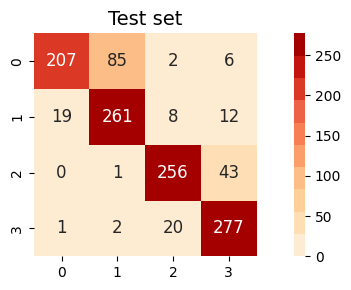

In [27]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_svm),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

### *Rete Neurale MLP*

In [28]:
best_mlp = gs_mlp.best_estimator_
y_test_pred_mlp = best_mlp.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_mlp))
print(classification_report(y_test, y_test_pred_mlp, digits=3))

Val Acc: 0.9566666666666667
              precision    recall  f1-score   support

           0      0.961     0.900     0.929       300
           1      0.906     0.963     0.934       300
           2      0.993     0.970     0.981       300
           3      0.971     0.993     0.982       300

    accuracy                          0.957      1200
   macro avg      0.958     0.957     0.957      1200
weighted avg      0.958     0.957     0.957      1200



**Confusion Matrix**

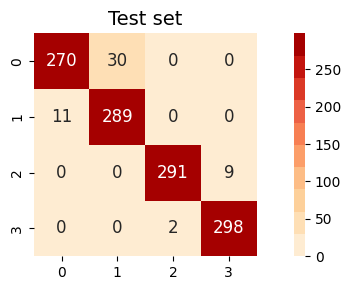

In [29]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

## 2.1.2 Classificazione Feature selection

In [43]:
X_train_sel_flat = ottieni_features(X_train_sel)
X_test_sel_flat = ottieni_features(X_test_sel)

In [44]:
param_grid_mlp_fs = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

gs_mlp_fs = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp_fs,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_mlp_fs.fit(X_train_sel_flat, y_train)

GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['logistic'],
                         'alpha': [0.001, 0.01, 0.1],
                         'batch_size': [30, 50, 70],
                         'hidden_layer_sizes': [(50,), (100,)],
                         'learning_rate': ['constant'],
                         'learning_rate_init': [0.01, 0.1],
                         'max_iter': [100, 200, 300], 'solver': ['sgd']},
             scoring='accuracy')

In [47]:
best_mlp_fs = gs_mlp_fs.best_estimator_
y_test_pred_mlp_fs = best_mlp_fs.predict(X_test_sel_flat)
print("Val Acc:", accuracy_score(y_test, y_test_pred_mlp_fs))
print(classification_report(y_test, y_test_pred_mlp_fs, digits=3))

Val Acc: 0.9291666666666667
              precision    recall  f1-score   support

           0      0.902     0.863     0.882       300
           1      0.868     0.900     0.884       300
           2      0.983     0.970     0.977       300
           3      0.964     0.983     0.974       300

    accuracy                          0.929      1200
   macro avg      0.929     0.929     0.929      1200
weighted avg      0.929     0.929     0.929      1200



**Confusion matrix**

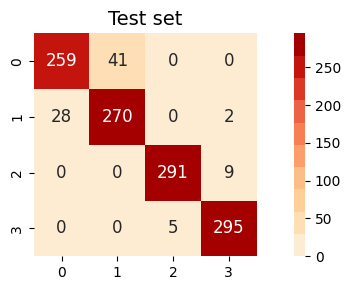

In [48]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp_fs),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

## 2.2 Classificazione nuove features

In [49]:
param_grid_mlp_geo = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  
    'alpha': [0.001, 0.01, 0.1],    
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [50]:
pipe_geo = Pipeline([('scaler', StandardScaler()),('classifier', GridSearchCV(MLPClassifier(random_state=42),param_grid_mlp_geo,cv=7,scoring='accuracy',n_jobs=-1))])

In [51]:
print("Tuning MLP...")
pipe_geo.fit(X_train_geo, y_train_geo)

Tuning MLP...


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'activation': ['logistic'],
                                          'alpha': [0.001, 0.01, 0.1],
                                          'batch_size': [30, 50, 70],
                                          'hidden_layer_sizes': [(50,), (100,)],
                                          'learning_rate': ['constant'],
                                          'learning_rate_init': [0.01, 0.1],
                                          'max_iter': [100, 200, 300],
                                          'solver': ['sgd']},
                              scoring='accuracy'))])

In [54]:
y_pred_mlp_geo = pipe_geo.predict(X_test_geo)
print("Val Accuracy: ", accuracy_score(y_test_geo, y_pred_mlp_geo))
print(classification_report(y_test_geo, y_pred_mlp_geo))

Val Accuracy:  0.9991666666666666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



**Confusion matrix**

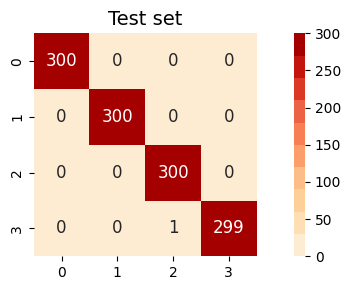

In [55]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test_geo, y_pred_mlp_geo),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

## 2.3 Classificazione Rappresentazione alternativa

In [56]:
param_grid_mlp_alt = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [57]:
gs_mlp_alt = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp_alt,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

In [58]:
start_time = time()
print("Tuning MLP...")
gs_mlp_alt.fit(X_train_alt_std, y_train_alt)
end_time = time()

Tuning MLP...


In [59]:
minuti_impiegati = (end_time-start_time)/60
print(f"Tempo trascorso in minuti: {minuti_impiegati:.2f}")
print("\nBest MLP params for alt:", gs_mlp_alt.best_params_)
print("Best accuracy:",      gs_mlp_alt.best_score_)

Tempo trascorso in minuti: 3.39

Best MLP params for alt: {'activation': 'logistic', 'alpha': 0.001, 'batch_size': 70, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 100, 'solver': 'sgd'}
Best accuracy: 0.9930031028161869


In [60]:
y_pred_mlp_alt = gs_mlp_alt.predict(X_test_alt_std)
print("Val Accuracy: ", accuracy_score(y_test_alt, y_pred_mlp_alt))
print(classification_report(y_test_alt, y_pred_mlp_alt))

Val Accuracy:  0.985
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       271
           1       1.00      1.00      1.00       245
           2       0.94      1.00      0.97       231
           3       1.00      0.98      0.99       253

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.98      0.99      1000



**Confusion Matrix**

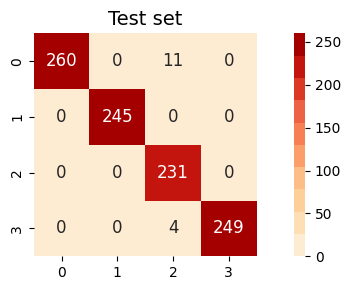

In [61]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test_alt, y_pred_mlp_alt),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

# 3. **Test di robustezza**


**Generazione primo dataset variato** con un maggiore rumore (1000,100,0.001)

In [62]:
X1, y1 = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.001)
X1_f = ottieni_features(X1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_f, y1, test_size=0.3)

**Generazione secondo dataset variato** con più esempi e features ma senza rumore (2000,200,0)

In [63]:
X2, y2 = genera_campioni(n_shapes=2000, n_punti=200, rumore_std_bound=0)
X2_f = ottieni_features(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_f, y2, test_size=0.3)

**Generazione terzo dataset variato** con molti meno esempi e features e molto più rumore (100,50,0.01)

In [64]:
X3, y3 = genera_campioni(n_shapes=100, n_punti=50, rumore_std_bound=0.01)
X3_f = ottieni_features(X3)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_f, y3, test_size=0.3)

In [65]:
param_grid_mlp_alt2 = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [66]:
gs_mlp_alt2 = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

Utilizzo di una pipeline con classificatore pari al migliore trovato per i dati precedenti

In [67]:
pipe = Pipeline([('scaler', StandardScaler()),('classifier', GridSearchCV(MLPClassifier(random_state=42),param_grid_mlp,cv=7,scoring='accuracy',n_jobs=-1))])

**Addestramento sul dataset con maggiore rumore**

In [68]:
pipe.fit(X1_train, y1_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'activation': ['logistic'],
                                          'alpha': [0.001, 0.01, 0.1],
                                          'batch_size': [30, 50, 70],
                                          'hidden_layer_sizes': [(25,), (50,)],
                                          'learning_rate': ['constant'],
                                          'learning_rate_init': [0.01, 0.1],
                                          'max_iter': [100, 200, 300],
                                          'solver': ['sgd']},
                              scoring='accuracy'))])

In [69]:
out_test_1 = pipe.predict(X1_test)
print("Val Acc:", accuracy_score(y1_test, out_test_1))
print(classification_report(y1_test, out_test_1))

Val Acc: 0.9225
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       281
           1       0.91      0.84      0.87       328
           2       0.98      0.98      0.98       282
           3       0.98      0.98      0.98       309

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200



**Addestramento su dataset con più esempi e più features e senza rumore**

In [70]:
pipe.fit(X2_train, y2_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'activation': ['logistic'],
                                          'alpha': [0.001, 0.01, 0.1],
                                          'batch_size': [30, 50, 70],
                                          'hidden_layer_sizes': [(25,), (50,)],
                                          'learning_rate': ['constant'],
                                          'learning_rate_init': [0.01, 0.1],
                                          'max_iter': [100, 200, 300],
                                          'solver': ['sgd']},
                              scoring='accuracy'))])

In [71]:
out_test_2 = pipe.predict(X2_test)
print("Val Acc:", accuracy_score(y2_test, out_test_2))
print(classification_report(y2_test, out_test_2))

Val Acc: 0.9720833333333333
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       609
           1       0.97      0.95      0.96       605
           2       0.99      0.98      0.98       592
           3       0.98      0.99      0.98       594

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400



**Addestramento sul dataset con meno campioni e meno features e maggiore rumore**

In [72]:
pipe.fit(X3_train, y3_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'activation': ['logistic'],
                                          'alpha': [0.001, 0.01, 0.1],
                                          'batch_size': [30, 50, 70],
                                          'hidden_layer_sizes': [(25,), (50,)],
                                          'learning_rate': ['constant'],
                                          'learning_rate_init': [0.01, 0.1],
                                          'max_iter': [100, 200, 300],
                                          'solver': ['sgd']},
                              scoring='accuracy'))])

In [73]:
out_test_3 = pipe.predict(X3_test)
print("Val Acc:", accuracy_score(y3_test, out_test_3))
print(classification_report(y3_test, out_test_3))

Val Acc: 0.7583333333333333
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        31
           1       0.54      0.52      0.53        27
           2       1.00      0.88      0.94        34
           3       0.85      1.00      0.92        28

    accuracy                           0.76       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.76      0.76      0.76       120



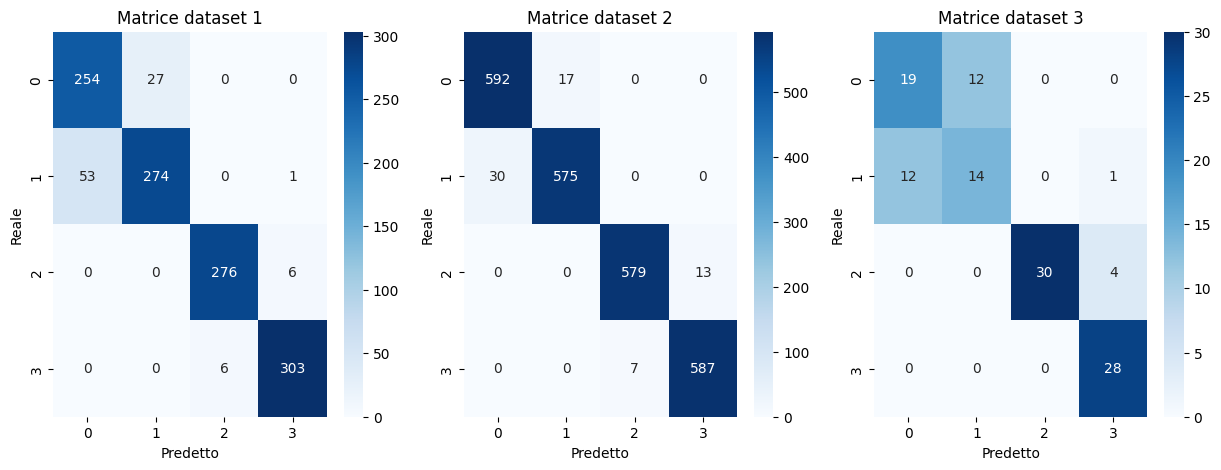

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
matrici = [
    confusion_matrix(y1_test, out_test_1),
    confusion_matrix(y2_test, out_test_2),
    confusion_matrix(y3_test, out_test_3)
]
for idx, cm in enumerate(matrici):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_xlabel('Predetto')
    axs[idx].set_ylabel('Reale')
    axs[idx].set_title(f'Matrice dataset {idx + 1}')


Possiamo notare come il dataset con piú esempi e piú feauters, con rumore assente, è quello dove il classificatore si comporta meglio, evitando comunque l'overfitting, anche se in un contesto più realistico, come nel primo dataset il classificatore si comporta comunque in maniera ottimale, con una leggera fatica a classificare correttamente rettangoli e ellissi

# 4. **Classificazione Binaria di forme ad area positiva o area nulla**

In [34]:
# Costruzione dataframe del training set
df_train_bin = pd.DataFrame(X_train_pca, y_train)  
df_train_bin['label'] = y_train
df_train_bin['label_bin'] = df_train_bin['label'].apply(lambda L: 1 if L in [0,1] else 0)
df_train_bin.drop(columns=['label'], inplace=True)
dataset_train = df_train_bin.to_numpy()
X_4_train = dataset_train[:, :-1]
y_4_train = dataset_train[:, -1]

# Costruzione dataframe del test set
df_test_bin = pd.DataFrame(X_test_pca, y_test)  
df_test_bin['label'] = y_test
df_test_bin['label_bin'] = df_test_bin['label'].apply(lambda L: 1 if L in [0,1] else 0)
df_test_bin.drop(columns=['label'], inplace=True)
dataset_test = df_test_bin.to_numpy()
X_4_test = dataset_test[:, :-1]
y_4_test = dataset_test[:, -1]

In [72]:
param_grid_lr = {
    'eta0': [0.0001 ,0.001, 0.01, 0.1, 1],
    'max_iter': [100, 200, 250, 300, 400],
    'penalty': [None, 'l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1]
}

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 7, 9, 12, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8, 10],
    
}

gs_lr = GridSearchCV(
    SGDClassifier(loss='log_loss', learning_rate='constant', random_state=42),
    param_grid_lr,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

In [73]:
start_time_lr = time()
print("Tuning Logistic Regression...")
gs_lr.fit(X_4_train, y_4_train)
end_time_lr = time()

start_time_dt = time()
print("Tuning Decision Tree...")
gs_dt.fit(X_4_train, y_4_train)
end_time_dt = time()

Tuning Logistic Regression...
Tuning Decision Tree...


In [74]:
minuti_impiegati_lr = (end_time_lr-start_time_lr)/60
print(f"Tempo trascorso in minuti LR: {minuti_impiegati_lr:.2f}")
print("\nBest LR params:", gs_lr.best_params_)
print("Best score: \n",    gs_lr.best_score_)

minuti_impiegati_dt = (end_time_dt-start_time_dt)/60
print(f"Tempo trascorso in minuti DT: {minuti_impiegati_dt:.2f}")
print("\nBest DT params:", gs_dt.best_params_)
print("Best score: \n",    gs_dt.best_score_)

Tempo trascorso in minuti LR: 0.07

Best LR params: {'alpha': 0.01, 'eta0': 0.001, 'max_iter': 100, 'penalty': 'l1'}
Best score: 
 0.6096428571428572
Tempo trascorso in minuti DT: 0.22

Best DT params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 
 0.9907142857142857


In [78]:
best_lr = gs_lr.best_estimator_
y_test_pred_lr = best_lr.predict(X_4_test)
print("Val Acc:", accuracy_score(y_4_test, y_test_pred_lr))
print(classification_report(y_4_test, y_test_pred_lr, digits=3))

Val Acc: 0.66
              precision    recall  f1-score   support

         0.0      0.710     0.542     0.614       600
         1.0      0.629     0.778     0.696       600

    accuracy                          0.660      1200
   macro avg      0.669     0.660     0.655      1200
weighted avg      0.669     0.660     0.655      1200



In [76]:
best_dt = gs_dt.best_estimator_
y_test_pred_dt = best_dt.predict(X_4_test)
print("Val Acc:", accuracy_score(y_4_test, y_test_pred_dt))
print(classification_report(y_4_test, y_test_pred_dt, digits=3))

Val Acc: 0.9916666666666667
              precision    recall  f1-score   support

         0.0      0.997     0.987     0.992       600
         1.0      0.987     0.997     0.992       600

    accuracy                          0.992      1200
   macro avg      0.992     0.992     0.992      1200
weighted avg      0.992     0.992     0.992      1200



**Confusion Matrix Decision Tree**

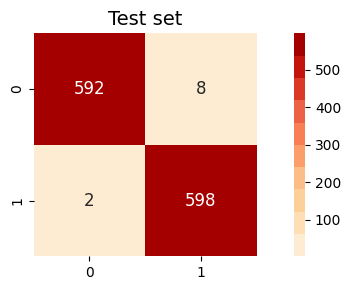

In [80]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_4_test, y_test_pred_dt),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

**Curva ROC**

- In questo caso la curva ROC va a visualizzare la curva sul rapporto tra True Positive e False Positive e la cui area sotto la curva (AUC) rappresenta una misura di qualità della predizione

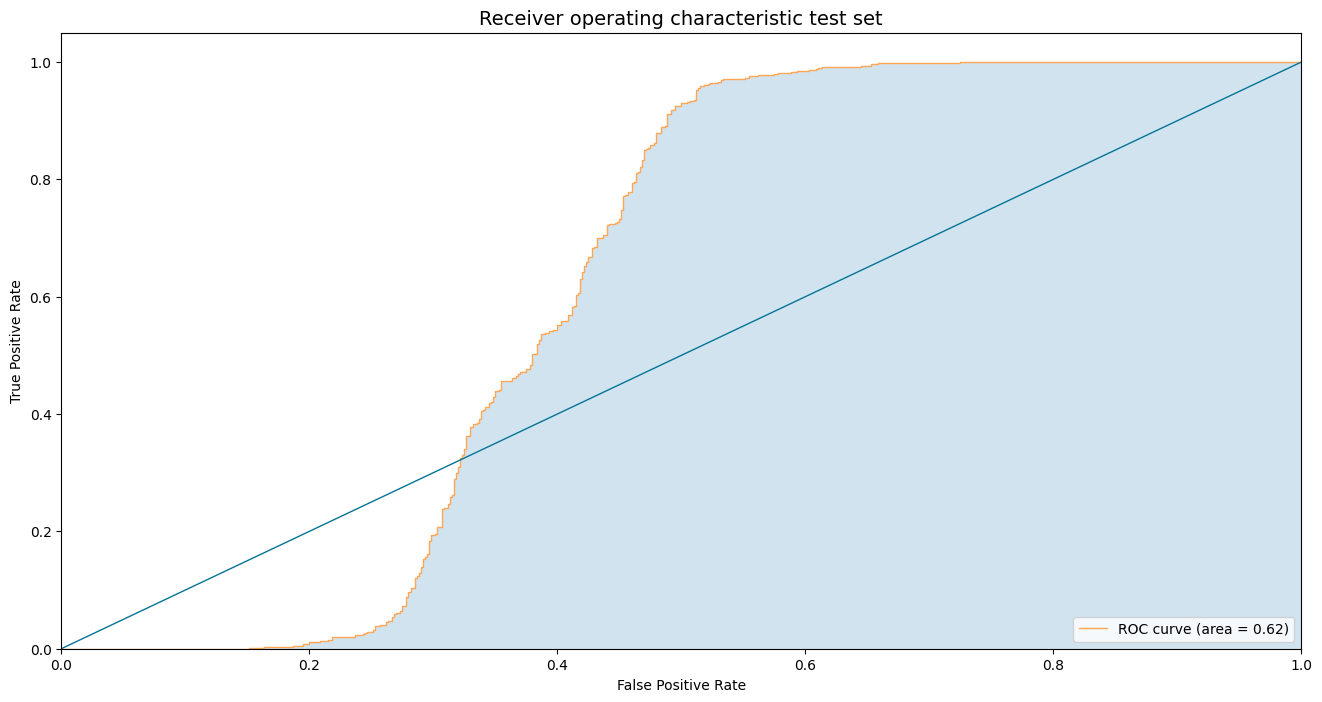

In [79]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = plt.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.35, 0.95, 256)))

fpr, tpr, thresholds = roc_curve(y_4_test, gs_lr.predict_proba(X_4_test)[:,1], pos_label=1)
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, color=colors[0], linewidth=1,label='ROC curve (area = %0.2f)' %  auc(fpr, tpr))
plt.fill_between(fpr, 0, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], color=colors[1], linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel(r'True Positive Rate')
plt.xlabel(r'False Positive Rate')
plt.title('Receiver operating characteristic test set', fontsize=14)
plt.legend(loc="lower right")
plt.show()